In [6]:
#       Code for Lab1 - PattRec

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [7]:
n1=6
n2=7

In [8]:

digit_map = {
    "zero": "0",
    "one": "1",
    "two": "2",
    "three": "3",
    "four": "4",
    "five": "5",
    "six": "6",
    "seven": "7",
    "eight": "8",
    "nine": "9",
}


def parse_audio_files(directory):
    wav_data = []  # Λίστα για το wav περιεχόμενο
    speakers = []  # Λίστα για τους ομιλητές
    digits = []  # Λίστα για τα ψηφία
    mfccs_list = []  
    mfsc_list = []      # List for MFSC
    
    # Διατρέχουμε όλα τα αρχεία στον φάκελο `digits/`
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            # Διαβάζουμε το wav αρχείο
            file_path = os.path.join(directory, filename)
            wav, _ = librosa.load(file_path, sr=None)
            _, Fs = librosa.core.load(file_path, sr=None)
            wav_data.append(wav)

            filename = os.path.splitext(filename)[0]
            # Διαχωρισμός ψηφίου και ομιλητή από το όνομα αρχείου
            digit_word = "".join([char for char in filename if char.isalpha()])
            speaker_id = "".join([char for char in filename if char.isdigit()])

            # Μετατροπή λέξης ψηφίου σε αριθμό
            digit = digit_map.get(digit_word, None)

            if digit is not None and speaker_id:
                digits.append(digit)
                speakers.append(speaker_id)


                # Extract MFCCs
                mfccs = librosa.feature.mfcc(y=wav, sr=Fs, n_mfcc=13, 
                                               hop_length=int(0.01 * Fs), 
                                               n_fft=int(0.025 * Fs))
                
                # Compute deltas and delta-deltas
                mfccs_delta = librosa.feature.delta(mfccs)
                mfccs_delta_delta = librosa.feature.delta(mfccs, order=2)

                # Combine MFCCs, deltas, and delta-deltas
                #mfccs_combined = np.vstack((mfccs, mfccs_delta, mfccs_delta_delta))
                mfccs_list.append((speaker_id, digit, mfccs))

                # Extract Mel Filterbank Spectral Coefficients
                mfsc = librosa.feature.melspectrogram(y=wav, sr=Fs, n_fft=int(0.025 * Fs), 
                                                       hop_length=int(0.01 * Fs), n_mels=40)
                
                mfsc_list.append((speaker_id, digit, mfsc))

            else:
                print(f"Error in file: {filename}")

    return wav_data, Fs, speakers, digits,  mfccs_list, mfsc_list


In [9]:

# Χρήση της συνάρτησης
wav_data, Fs, speakers, digits ,mfccs_list, mfsc_list = parse_audio_files("/Users/mariasabani/Desktop/Patern Recognition/pr_lab2_data/digits")

In [10]:
print(mfccs_list)

[('3', '3', array([[-7.70007324e+02, -7.44616394e+02, -7.46043213e+02,
        -7.32131897e+02, -7.32543701e+02, -7.14395203e+02,
        -6.99014465e+02, -7.15322205e+02, -7.36903137e+02,
        -7.36158203e+02, -7.32573303e+02, -7.32071960e+02,
        -4.37736206e+02, -3.86977295e+02, -4.54624634e+02,
        -4.35094910e+02, -4.74483673e+02, -4.01360474e+02,
        -3.80276886e+02, -3.81092651e+02, -3.80783722e+02,
        -3.94252167e+02, -4.14236816e+02, -4.08999237e+02,
        -4.23037628e+02, -4.58178772e+02, -4.02691010e+02,
        -3.97323395e+02, -4.08669403e+02, -4.11239929e+02,
        -4.08843842e+02, -4.02356140e+02, -4.04492340e+02,
        -4.06220184e+02, -4.12983246e+02, -4.17945862e+02,
        -4.43179779e+02, -4.70715302e+02, -4.96753540e+02,
        -5.62266907e+02, -5.83245117e+02, -6.06216370e+02,
        -6.26750610e+02, -6.36437195e+02, -6.49619507e+02,
        -6.70280701e+02, -6.94022583e+02, -7.06864014e+02,
        -6.99847656e+02, -7.33224731e+02, -7

In [11]:
print(len(mfccs_list[0][2]))

13


In [12]:
def plot_histograms(mfccs_list, speakers, target_digit="1"):
    # Filter MFCCs for the target digit
    mfccs_for_digit = [(speaker_id, mfccs) for speaker_id, digit, mfccs in mfccs_list if digit == target_digit]

    if not mfccs_for_digit:
        print(f"No MFCCs found for digit {target_digit}.")
        return

    # Plot histograms for all speakers in one plot
    plt.figure(figsize=(12, 6))

    # Use a color map to differentiate speakers
    colors = plt.cm.get_cmap('tab10', len(mfccs_for_digit))

    for i, (speaker_id, mfccs) in enumerate(mfccs_for_digit):
        plt.hist(mfccs.flatten(), bins=50, alpha=0.5, color=colors(i), label=f'Speaker {speaker_id}')

    plt.title(f'Histogram of MFCCs for Digit {target_digit}')
    plt.xlabel('MFCC Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


/var/folders/29/__jq0p8579nf72bcn7t9y_3c0000gn/T/ipykernel_47338/1575894516.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(mfccs_for_digit))


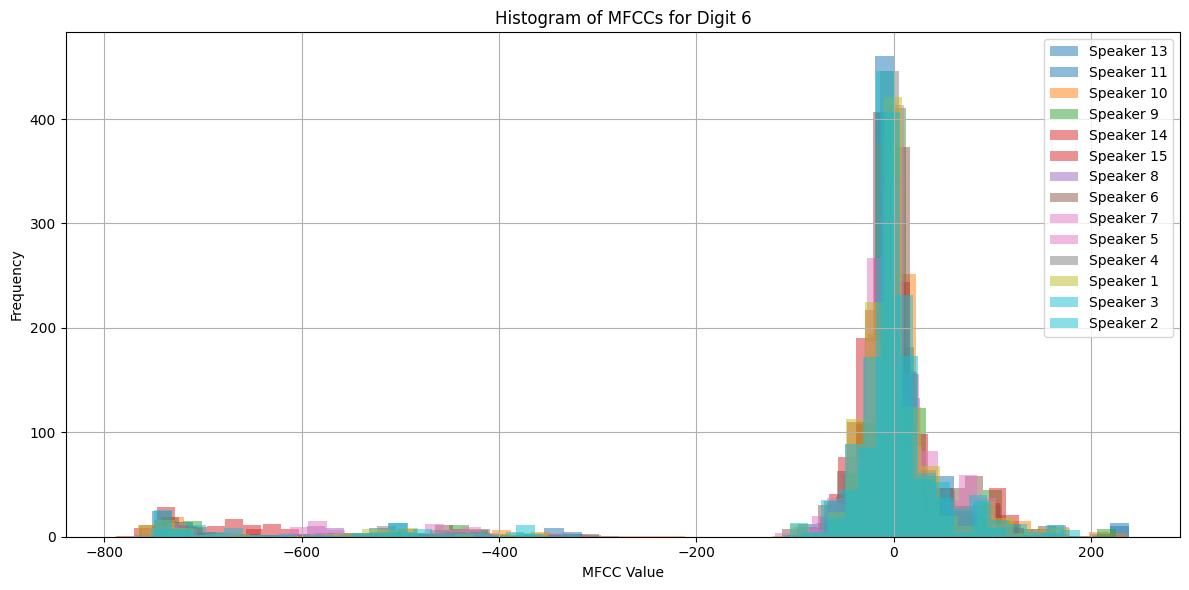

In [13]:

plot_histograms(mfccs_list, speakers,target_digit=str(n1))


In [14]:
def plot_histograms_2(mfccs_list, speakers, target_digits=["1", "2"]):
    # Define distinct colors for each target digit
    color_map = {
        target_digits[0]: "blue",
        target_digits[1]: "red"
    }

    plt.figure(figsize=(12, 6))

    for target_digit in target_digits:
        # Filter MFCCs for the target digit
        mfccs_for_digit = [(speaker_id, mfccs) for speaker_id, digit, mfccs in mfccs_list if digit == target_digit]

        if not mfccs_for_digit:
            print(f"No MFCCs found for digit {target_digit}.")
            continue

        for speaker_id, mfccs in mfccs_for_digit:
            # Plot histogram with a distinct color for each digit
            plt.hist(
                mfccs.flatten(), 
                bins=50, 
                alpha=0.5, 
                color=color_map[target_digit], 
                label=f'Digit {target_digit} - Speaker {speaker_id}'
            )

    # Set plot title, labels, and legend
    plt.title(f'Histogram of MFCCs for Digits {", ".join(target_digits)}')
    plt.xlabel('MFCC Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [15]:
# Select samples based on conditions
selected_samples_mfsc_list = []

selected_samples_mfsc_list.extend([row for row in mfsc_list if int(row[0]) == 1 and int(row[1]) == 6][:1])
selected_samples_mfsc_list.extend([row for row in mfsc_list if int(row[0]) == 2 and int(row[1]) == 6][:1])

# Select samples with first element 1 and second element 7 and 2
selected_samples_mfsc_list.extend([row for row in mfsc_list if int(row[0]) == 1 and int(row[1]) == 7][:1])
selected_samples_mfsc_list.extend([row for row in mfsc_list if int(row[0]) == 2 and int(row[1]) == 7][:1])

# Convert to numpy array if needed
selected_samples_mfsc_list = np.array(selected_samples_mfsc_list, dtype=object)  # dtype=object to handle nested arrays


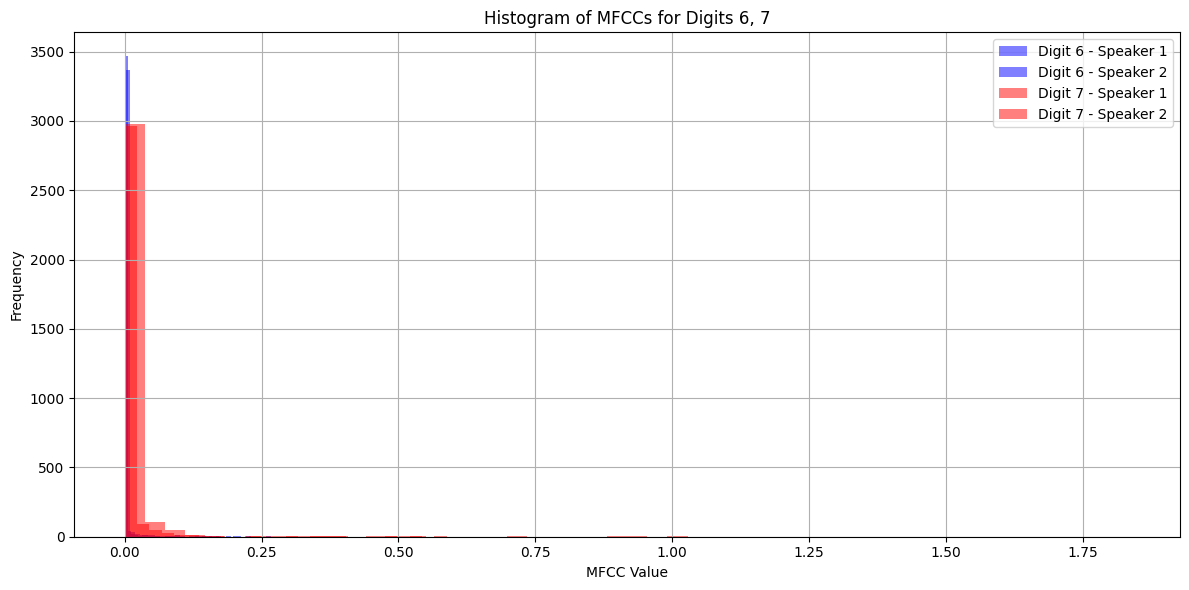

In [16]:
plot_histograms_2(selected_samples_mfsc_list, speakers,target_digits=[str(n1),str(n2)])

In [17]:
# Select samples based on conditions
selected_samples_mfcc_list = []

selected_samples_mfcc_list.extend([row for row in mfccs_list if int(row[0]) == 1 and int(row[1]) == 6][:1])
selected_samples_mfcc_list.extend([row for row in mfccs_list if int(row[0]) == 2 and int(row[1]) == 6][:1])

# Select samples with first element 1 and second element 7 and 2
selected_samples_mfcc_list.extend([row for row in mfccs_list if int(row[0]) == 1 and int(row[1]) == 7][:1])
selected_samples_mfcc_list.extend([row for row in mfccs_list if int(row[0]) == 2 and int(row[1]) == 7][:1])

# Convert to numpy array if needed
selected_samples_mfcc_list = np.array(selected_samples_mfcc_list, dtype=object)  # dtype=object to handle nested arrays


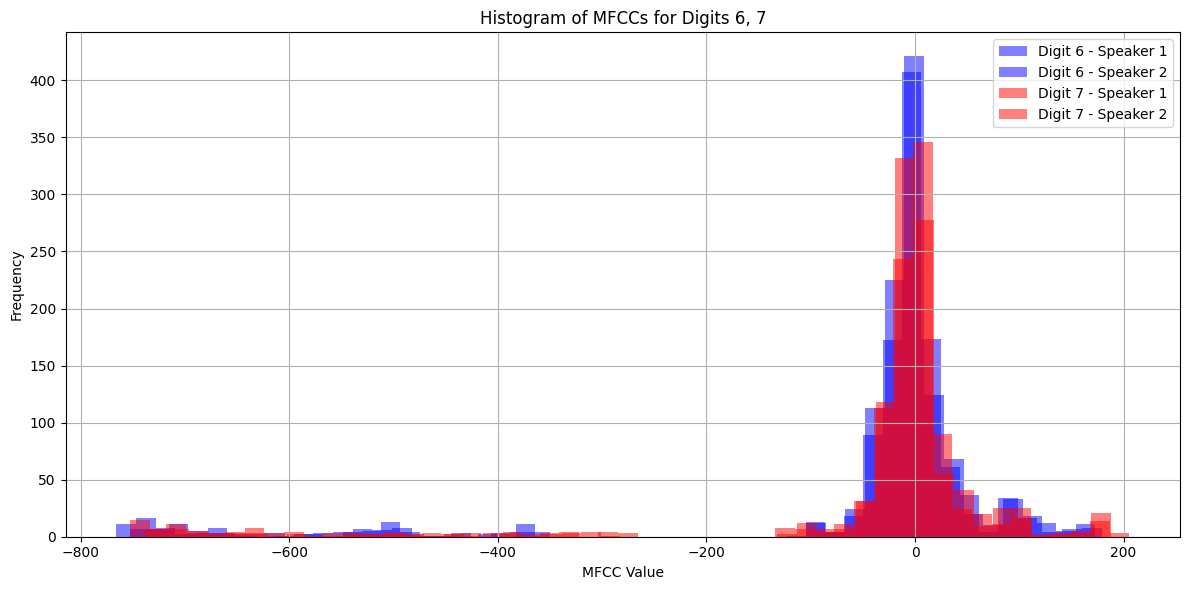

In [18]:
plot_histograms_2(selected_samples_mfcc_list, speakers,target_digits=[str(n1),str(n2)])


In [19]:
def parse_audio_files_comb(directory):
    wav_data = []  # Λίστα για το wav περιεχόμενο
    speakers = []  # Λίστα για τους ομιλητές
    digits = []  # Λίστα για τα ψηφία
    mfccs_list_combined = []  
    
    # Διατρέχουμε όλα τα αρχεία στον φάκελο `digits/`
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            # Διαβάζουμε το wav αρχείο
            file_path = os.path.join(directory, filename)
            wav, _ = librosa.load(file_path, sr=None)
            _, Fs = librosa.core.load(file_path, sr=None)
            wav_data.append(wav)

            filename = os.path.splitext(filename)[0]
            # Διαχωρισμός ψηφίου και ομιλητή από το όνομα αρχείου
            digit_word = "".join([char for char in filename if char.isalpha()])
            speaker_id = "".join([char for char in filename if char.isdigit()])

            # Μετατροπή λέξης ψηφίου σε αριθμό
            digit = digit_map.get(digit_word, None)

            if digit is not None and speaker_id:
                digits.append(digit)
                speakers.append(speaker_id)


                # Extract MFCCs
                mfccs = librosa.feature.mfcc(y=wav, sr=Fs, n_mfcc=13, 
                                               hop_length=int(0.01 * Fs), 
                                               n_fft=int(0.025 * Fs))
                
                # Compute deltas and delta-deltas
                mfccs_delta = librosa.feature.delta(mfccs)
                mfccs_delta_delta = librosa.feature.delta(mfccs, order=2)

                # Combine MFCCs, deltas, and delta-deltas
                mfccs_combined = np.vstack((mfccs, mfccs_delta, mfccs_delta_delta))
                mfccs_list_combined.append((speaker_id, digit, mfccs_combined))


            else:
                print(f"Error in file: {filename}")

    return mfccs_list_combined


In [21]:
mfccs_list_combined = parse_audio_files_comb("/Users/mariasabani/Desktop/Patern Recognition/pr_lab2_data/digits")

In [22]:
# Shape is [ (speaker, digit ,   39 arrays(dimentions) of 75 elements) , ( .wav .... ) , ( ...  ), ..    ]
print(mfccs_list_combined[0])

('3', '3', array([[-7.70007324e+02, -7.44616394e+02, -7.46043213e+02, ...,
        -6.62716125e+02, -6.55939514e+02, -6.77914429e+02],
       [ 6.98528290e+01,  7.97097778e+01,  9.30650024e+01, ...,
         1.19235176e+02,  1.25063751e+02,  1.07140900e+02],
       [ 3.46133089e+00, -6.50508118e+00,  1.13838625e+01, ...,
        -2.96951714e+01, -2.84832268e+01, -2.60342884e+01],
       ...,
       [ 3.72457474e-01,  3.72457474e-01,  3.72457474e-01, ...,
         2.58546501e-01,  2.58546501e-01,  2.58546501e-01],
       [ 6.20872498e-01,  6.20872498e-01,  6.20872498e-01, ...,
        -2.29246989e-01, -2.29246989e-01, -2.29246989e-01],
       [ 1.87234446e-01,  1.87234446e-01,  1.87234446e-01, ...,
        -1.22088253e+00, -1.22088253e+00, -1.22088253e+00]], dtype=float32))


In [23]:
print(mfccs_list_combined)

[('3', '3', array([[-7.70007324e+02, -7.44616394e+02, -7.46043213e+02, ...,
        -6.62716125e+02, -6.55939514e+02, -6.77914429e+02],
       [ 6.98528290e+01,  7.97097778e+01,  9.30650024e+01, ...,
         1.19235176e+02,  1.25063751e+02,  1.07140900e+02],
       [ 3.46133089e+00, -6.50508118e+00,  1.13838625e+01, ...,
        -2.96951714e+01, -2.84832268e+01, -2.60342884e+01],
       ...,
       [ 3.72457474e-01,  3.72457474e-01,  3.72457474e-01, ...,
         2.58546501e-01,  2.58546501e-01,  2.58546501e-01],
       [ 6.20872498e-01,  6.20872498e-01,  6.20872498e-01, ...,
        -2.29246989e-01, -2.29246989e-01, -2.29246989e-01],
       [ 1.87234446e-01,  1.87234446e-01,  1.87234446e-01, ...,
        -1.22088253e+00, -1.22088253e+00, -1.22088253e+00]], dtype=float32)), ('12', '4', array([[-7.5967157e+02, -7.3898785e+02, -7.4399524e+02, ...,
        -7.2604803e+02, -7.2762720e+02, -7.4194366e+02],
       [ 6.8732803e+01,  7.2957146e+01,  7.1070755e+01, ...,
         9.0552582e+01,

In [24]:
# Initialize lists to hold means and standard deviations
import numpy as np

# Assuming mfccs_list_combined is already defined and structured as described
means_list = []
std_devs_list = []
speakers = []
digits = []
total_list = []  # Initialize as an empty list

for i, sublist in enumerate(mfccs_list_combined):
    # Extract the sublists from the 3rd dimension
    data_array = np.array(sublist[2])  # Assuming the MFCCs are at index [2]
    
    # Get the speaker and digit information
    speaker, digit = sublist[0], sublist[1]
    speakers.append(speaker)
    digits.append(digit)
    
    # Calculate mean and standard deviation across the first axis (list axis)
    means = np.mean(data_array, axis=0)      # Mean for each dimension (75 dimensions)
    std_devs = np.std(data_array, axis=0)    # Standard deviation for each dimension (75 dimensions)
    
    # Append results to the means and std_devs lists
    means_list.append(means.tolist())
    std_devs_list.append(std_devs.tolist())
    
    # Create a new entry for total_list for this iteration
    total_list.append([digits[i], speakers[i], means.tolist(), std_devs.tolist()])

# Display the results
print(f"List of speakers: {speakers}")
print(f"List of digits: {digits}")
print(f"Total List: {total_list}")


List of speakers: ['3', '12', '8', '5', '5', '4', '4', '9', '13', '2', '11', '6', '6', '7', '7', '10', '1', '14', '5', '3', '3', '2', '2', '4', '15', '6', '1', '1', '7', '8', '11', '2', '14', '5', '4', '15', '3', '10', '9', '13', '11', '14', '12', '1', '6', '15', '13', '10', '9', '14', '11', '3', '12', '4', '5', '13', '2', '10', '15', '8', '8', '12', '14', '7', '11', '10', '6', '1', '13', '15', '9', '4', '13', '6', '1', '7', '5', '12', '5', '10', '7', '2', '14', '8', '9', '15', '3', '11', '6', '4', '2', '15', '7', '11', '10', '6', '3', '14', '1', '1', '3', '4', '9', '12', '13', '8', '5', '2', '1', '11', '10', '9', '15', '2', '12', '13', '3', '14', '8', '7', '10', '11', '6', '4', '13', '9', '14', '9', '8', '15', '12', '8', '5']
List of digits: ['3', '4', '2', '1', '9', '9', '1', '2', '4', '3', '4', '1', '9', '9', '1', '4', '3', '4', '3', '1', '9', '9', '1', '3', '4', '3', '9', '1', '3', '4', '9', '5', '8', '8', '8', '8', '5', '9', '4', '6', '6', '2', '9', '5', '8', '2', '9', '6', '6', '

/var/folders/29/__jq0p8579nf72bcn7t9y_3c0000gn/T/ipykernel_47338/1898709552.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10)  # Get a colormap with 10 different colors


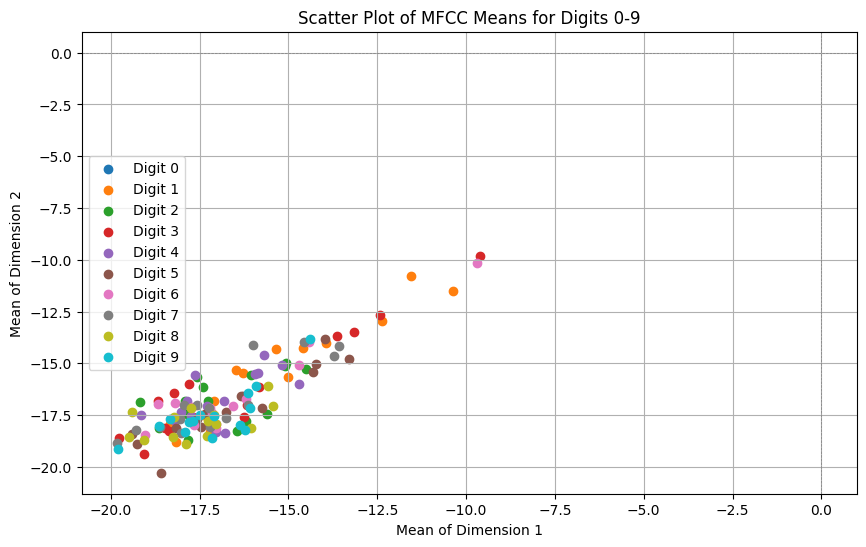

In [25]:
colors = plt.cm.get_cmap('tab10', 10)  # Get a colormap with 10 different colors

# Create a scatter plot for all digits
plt.figure(figsize=(10, 6))

for j in range(10):
    # Filter points for the current digit
    filtered_points = [
        (entry[2][0], entry[2][1])  # Take the first two dimensions of the means
        for entry in total_list if entry[0] == str(j)
    ]

    # Unzip the filtered points into x and y coordinates
    x_coords, y_coords = zip(*filtered_points) if filtered_points else ([], [])

    # Scatter plot for the current digit
    plt.scatter(x_coords, y_coords, marker='o', color=colors(j), label=f'Digit {j}')

# Adding titles and labels
plt.title('Scatter Plot of MFCC Means for Digits 0-9')
plt.xlabel('Mean of Dimension 1')
plt.ylabel('Mean of Dimension 2')
plt.axhline(0, color='grey', lw=0.5, ls='--')  # Add a horizontal line at y=0
plt.axvline(0, color='grey', lw=0.5, ls='--')  # Add a vertical line at x=0
plt.grid(True)
plt.legend()
plt.show()

/var/folders/29/__jq0p8579nf72bcn7t9y_3c0000gn/T/ipykernel_47338/997572850.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10)  # Get a colormap with 10 different colors


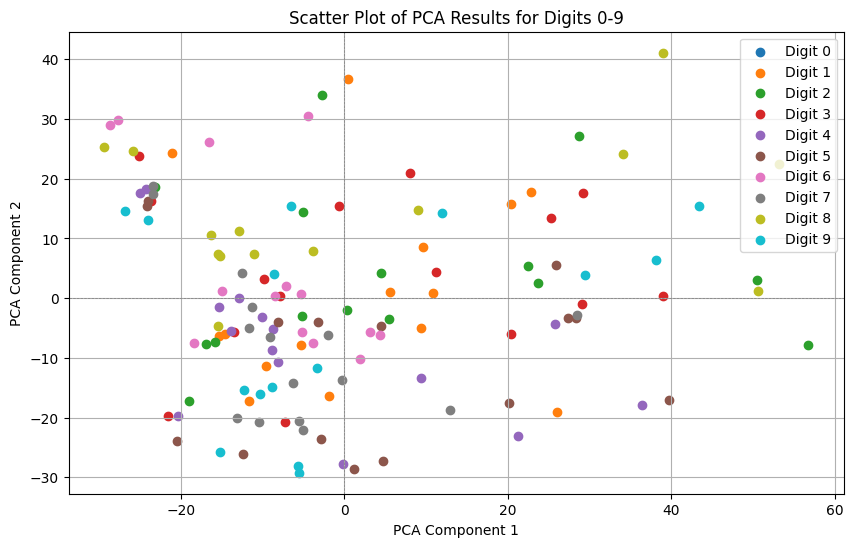

In [26]:

from sklearn.decomposition import PCA

# Define the target length
target_length = 75

# Initialize lists to hold means and labels
means_list = []
labels = []

# Extract means and corresponding digits from total_list
for entry in total_list:
    digit, speaker, means_vector, std_dev = entry
    
    # Check the length of the means vector and pad or truncate as necessary
    if len(means_vector) < target_length:
        # Pad with zeros
        padded_vector = np.pad(means_vector, (0, target_length - len(means_vector)), 'constant')
    elif len(means_vector) > target_length:
        # Truncate the vector to the target length
        padded_vector = means_vector[:target_length]
    else:
        padded_vector = means_vector  # It is already the correct length
    
    # Append the processed vector and label
    means_list.append(padded_vector)  
    labels.append(digit)              

# Convert means_list to a NumPy array
data_for_pca = np.array(means_list)

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
pca_results_2 = pca.fit_transform(data_for_pca)

# Create a scatter plot for PCA results
plt.figure(figsize=(10, 6))

# Define a color map for different digits
colors = plt.cm.get_cmap('tab10', 10)  # Get a colormap with 10 different colors

# Scatter plot for all digits
for j in range(10):
    # Filter points for the current digit
    filtered_points = [
        (pca_results_2[i, 0], pca_results_2[i, 1])  # Take the PCA transformed coordinates
        for i, digit in enumerate(labels) if digit == str(j)
    ]

    # Unzip the filtered points into x and y coordinates
    x_coords, y_coords = zip(*filtered_points) if filtered_points else ([], [])

    # Scatter plot for the current digit
    plt.scatter(x_coords, y_coords, marker='o', color=colors(j), label=f'Digit {j}')

# Adding titles and labels
plt.title('Scatter Plot of PCA Results for Digits 0-9')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.axhline(0, color='grey', lw=0.5, ls='--')  # Add a horizontal line at y=0
plt.axvline(0, color='grey', lw=0.5, ls='--')  # Add a vertical line at x=0
plt.grid(True)
plt.legend()
plt.show()

/var/folders/29/__jq0p8579nf72bcn7t9y_3c0000gn/T/ipykernel_47338/429589767.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10)  # Get a colormap with 10 different colors


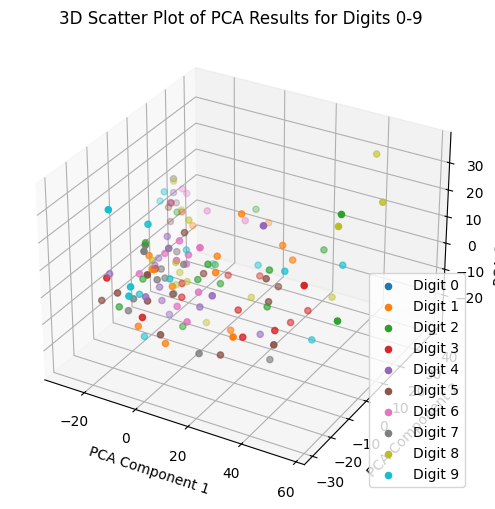

In [86]:
target_length = 75

# Initialize lists to hold means and labels
means_list = []
labels = []

# Extract means and corresponding digits from total_list
for entry in total_list:
    digit, speaker, means_vector, std_dev = entry
    
    # Check the length of the means vector and pad or truncate as necessary
    if len(means_vector) < target_length:
        # Pad with zeros
        padded_vector = np.pad(means_vector, (0, target_length - len(means_vector)), 'constant')
    elif len(means_vector) > target_length:
        # Truncate the vector to the target length
        padded_vector = means_vector[:target_length]
    else:
        padded_vector = means_vector  # It is already the correct length
    
    # Append the processed vector and label
    means_list.append(padded_vector)  
    labels.append(digit)              

# Convert means_list to a NumPy array
data_for_pca = np.array(means_list)

# Apply PCA to reduce the dimensionality to 3
pca_3 = PCA(n_components=3)
pca_results_3 = pca_3.fit_transform(data_for_pca)

# Create a 3D scatter plot for PCA results
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Define a color map for different digits
colors = plt.cm.get_cmap('tab10', 10)  # Get a colormap with 10 different colors

# Scatter plot for all digits
for j in range(10):
    # Filter points for the current digit
    filtered_points = [
        (pca_results_3[i, 0], pca_results_3[i, 1], pca_results_3[i, 2])  # Take the PCA transformed coordinates
        for i, digit in enumerate(labels) if digit == str(j)
    ]

    # Unzip the filtered points into x, y, and z coord
    # inates
    x_coords, y_coords, z_coords = zip(*filtered_points) if filtered_points else ([], [], [])

    # Scatter plot for the current digit
    ax.scatter(x_coords, y_coords, z_coords, marker='o', color=colors(j), label=f'Digit {j}')

# Adding titles and labels
ax.set_title('3D Scatter Plot of PCA Results for Digits 0-9')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.grid(True)
ax.legend()
plt.show()

In [87]:
pca_array_3 = np.array(pca_results_3)

# Calculate the standard deviation for each PCA dimension
std_devs = np.std(pca_array_3, axis=0)
print(std_devs)

[19.95046852 15.8374874  11.98344594]


In [89]:
pca_array_2 = np.array(pca_results_2)

# Calculate the standard deviation for each PCA dimension
std_devs_2 = np.std(pca_array_2, axis=0)
print(std_devs_2)

[19.95046852 15.8374874 ]


In [88]:
print(total_list[0][3][0],total_list[0][3][1])

122.46504974365234 118.60874938964844


In [31]:
print(len(total_list))

133


In [90]:
target_labels=[]
for item in total_list:
    target_labels.append(item[0])
print(len(target_labels))

print(len(pca_array_3))

133
133


In [91]:
mean_list_final=[]

for item in total_list:
    mean_list_final.append(item[2])
    #print(len(item[2]))



In [92]:
print(len(pca_array_2))

133


In [93]:
target_length = 90

# Initialize lists to hold means and labels
means_list = []
labels = []

# Extract means and corresponding digits from total_list
for entry in total_list:
    digit, speaker, means_vector, std_dev = entry
    
    # Check the length of the means vector and pad or truncate as necessary
    if len(means_vector) < target_length:
        # Pad with zeros
        padded_vector = np.pad(means_vector, (0, target_length - len(means_vector)), 'constant')
    elif len(means_vector) > target_length:
        # Truncate the vector to the target length
        padded_vector = means_vector[:target_length]
    else:
        padded_vector = means_vector  # It is already the correct length
    
    # Append the processed vector and label
    means_list.append(padded_vector)  
    labels.append(digit)              

# Convert means_list to a NumPy array
data_for_pca = np.array(means_list)

# Apply PCA to reduce the dimensionality to 3
pca_70 = PCA(n_components=70)
pca_results_30 = pca_70.fit_transform(data_for_pca)

In [95]:

X = np.array(pca_results_3)  # Feature set (numpy array)
y = np.array(target_labels)   # Labels (numpy array)

# Split the data into training and testing sets with a 70%-30% ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "Gaussian Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Classifier": SVC()
}

# Train classifiers and evaluate
results = {}

for name, clf in classifiers.items():
    clf.fit(X_train_normalized, y_train)  # Train the classifier
    y_pred = clf.predict(X_test_normalized)  # Predict on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[name] = accuracy  # Store the accuracy

# Display results
for name, accuracy in results.items():
    print(f"{name} accuracy: {accuracy * 100:.2f}%")



Gaussian Naive Bayes accuracy: 17.50%
Logistic Regression accuracy: 15.00%
Random Forest accuracy: 20.00%
Support Vector Classifier accuracy: 15.00%


Epoch 1 -> Loss: 0.4905
Epoch 2 -> Loss: 0.4546
Epoch 3 -> Loss: 0.4151
Epoch 4 -> Loss: 0.3694
Epoch 5 -> Loss: 0.3185
Epoch 6 -> Loss: 0.2644
Epoch 7 -> Loss: 0.2089
Epoch 8 -> Loss: 0.1527
Epoch 9 -> Loss: 0.1005
Epoch 10 -> Loss: 0.0630
Epoch 11 -> Loss: 0.0389
Epoch 12 -> Loss: 0.0377
Epoch 13 -> Loss: 0.0511
Epoch 14 -> Loss: 0.0642
Epoch 15 -> Loss: 0.0592
Epoch 16 -> Loss: 0.0478
Epoch 17 -> Loss: 0.0324
Epoch 18 -> Loss: 0.0175
Epoch 19 -> Loss: 0.0081
Epoch 20 -> Loss: 0.0058
Epoch 21 -> Loss: 0.0095
Epoch 22 -> Loss: 0.0142
Epoch 23 -> Loss: 0.0176
Epoch 24 -> Loss: 0.0188
Epoch 25 -> Loss: 0.0185
Epoch 26 -> Loss: 0.0170
Epoch 27 -> Loss: 0.0143
Epoch 28 -> Loss: 0.0107
Epoch 29 -> Loss: 0.0072
Epoch 30 -> Loss: 0.0051
Epoch 31 -> Loss: 0.0053
Epoch 32 -> Loss: 0.0067
Epoch 33 -> Loss: 0.0077
Epoch 34 -> Loss: 0.0078
Epoch 35 -> Loss: 0.0076
Epoch 36 -> Loss: 0.0071
Epoch 37 -> Loss: 0.0055
Epoch 38 -> Loss: 0.0035
Epoch 39 -> Loss: 0.0022
Epoch 40 -> Loss: 0.0019
Epoch 41 

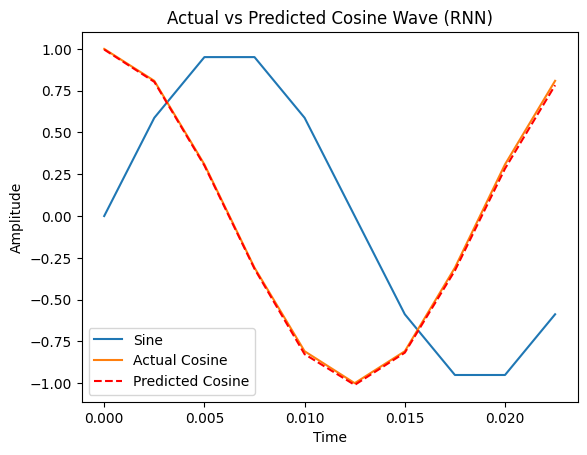

In [115]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Parameters
f = 40  # frequency in Hz
T = 1 / f  # period
sample_points = 10  # points per period
t = np.linspace(0, T, sample_points, endpoint=False)  # sampling times

# Generate sine and cosine sequences
sine_wave = np.sin(2 * np.pi * f * t)  # sine
cosine_wave = np.cos(2 * np.pi * f * t)  # cosine

# Convert to PyTorch tensors
sine_wave_tensor = torch.tensor(sine_wave, dtype=torch.float32).view(1, sample_points, 1)
cosine_wave_tensor = torch.tensor(cosine_wave, dtype=torch.float32).view(1, sample_points, 1)

# Define the RNN model to output the full sequence
class SineToCosineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SineToCosineRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)  # Get the RNN outputs for all time steps
        output = self.fc(rnn_out)  # Pass through the fully connected layer for each time step
        return output

# Initialize model, loss, and optimizer
input_size = 1
hidden_size = 16
output_size = 1
model = SineToCosineRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(sine_wave_tensor)  # Get predictions for all time steps
    loss = criterion(output, cosine_wave_tensor)  # Compare each predicted value with the actual cosine
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1} -> Loss: {loss.item():.4f}')

# Evaluation and visualization
model.eval()
predicted_cosine = model(sine_wave_tensor).detach().numpy().flatten()

# Plot the actual vs predicted cosine wave
plt.plot(t, sine_wave, label='Sine')
plt.plot(t, cosine_wave, label='Actual Cosine')
plt.plot(t, predicted_cosine, 'r--', label='Predicted Cosine')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Actual vs Predicted Cosine Wave (RNN)')
plt.show()


Epoch 1 -> Loss: 0.5592
Epoch 2 -> Loss: 0.5347
Epoch 3 -> Loss: 0.5149
Epoch 4 -> Loss: 0.4969
Epoch 5 -> Loss: 0.4785
Epoch 6 -> Loss: 0.4579
Epoch 7 -> Loss: 0.4339
Epoch 8 -> Loss: 0.4059
Epoch 9 -> Loss: 0.3740
Epoch 10 -> Loss: 0.3396
Epoch 11 -> Loss: 0.3043
Epoch 12 -> Loss: 0.2677
Epoch 13 -> Loss: 0.2277
Epoch 14 -> Loss: 0.1843
Epoch 15 -> Loss: 0.1416
Epoch 16 -> Loss: 0.1071
Epoch 17 -> Loss: 0.0846
Epoch 18 -> Loss: 0.0710
Epoch 19 -> Loss: 0.0657
Epoch 20 -> Loss: 0.0655
Epoch 21 -> Loss: 0.0613
Epoch 22 -> Loss: 0.0664
Epoch 23 -> Loss: 0.0707
Epoch 24 -> Loss: 0.0699
Epoch 25 -> Loss: 0.0652
Epoch 26 -> Loss: 0.0519
Epoch 27 -> Loss: 0.0409
Epoch 28 -> Loss: 0.0316
Epoch 29 -> Loss: 0.0241
Epoch 30 -> Loss: 0.0207
Epoch 31 -> Loss: 0.0198
Epoch 32 -> Loss: 0.0191
Epoch 33 -> Loss: 0.0193
Epoch 34 -> Loss: 0.0202
Epoch 35 -> Loss: 0.0208
Epoch 36 -> Loss: 0.0204
Epoch 37 -> Loss: 0.0197
Epoch 38 -> Loss: 0.0183
Epoch 39 -> Loss: 0.0161
Epoch 40 -> Loss: 0.0133
Epoch 41 

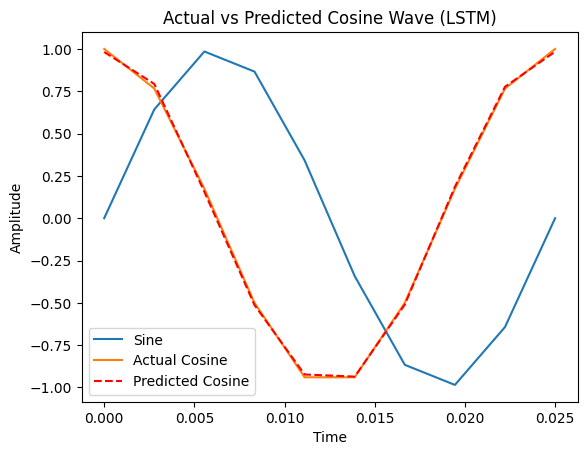

In [116]:
# Parameters
f = 40  # frequency in Hz
T = 1 / f  # period
sample_points = 10  # points per period
t = np.linspace(0, T, sample_points, endpoint=True)  # sampling times

# Generate sine and cosine sequences
sine_wave = np.sin(2 * np.pi * f * t)  # sine
cosine_wave = np.cos(2 * np.pi * f * t)  # cosine

# Convert to PyTorch tensors
sine_wave_tensor = torch.tensor(sine_wave, dtype=torch.float32).view(1, sample_points, 1)
cosine_wave_tensor = torch.tensor(cosine_wave, dtype=torch.float32).view(1, sample_points, 1)

# Define the RNN model to output the full sequence
class SineToCosineLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SineToCosineLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Get the LSTM outputs for all time steps
        output = self.fc(lstm_out)  # Pass through the fully connected layer for each time step
        return output

# Initialize model, loss, and optimizer
input_size = 1
hidden_size = 16
output_size = 1
model = SineToCosineLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(sine_wave_tensor)  # Get predictions for all time steps
    loss = criterion(output, cosine_wave_tensor)  # Compare each predicted value with the actual cosine
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1} -> Loss: {loss.item():.4f}')


# Evaluation and visualization
model.eval()
predicted_cosine = model(sine_wave_tensor).detach().numpy().flatten()

# Plot the actual vs predicted cosine wave
plt.plot(t, sine_wave, label='Sine')
plt.plot(t, cosine_wave, label='Actual Cosine')
plt.plot(t, predicted_cosine, 'r--', label='Predicted Cosine')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Actual vs Predicted Cosine Wave (LSTM)')
plt.show()


Epoch 1, Loss: 0.5765
Epoch 2, Loss: 0.5438
Epoch 3, Loss: 0.5170
Epoch 4, Loss: 0.4943
Epoch 5, Loss: 0.4738
Epoch 6, Loss: 0.4533
Epoch 7, Loss: 0.4306
Epoch 8, Loss: 0.4045
Epoch 9, Loss: 0.3755
Epoch 10, Loss: 0.3451
Epoch 11, Loss: 0.3161
Epoch 12, Loss: 0.2903
Epoch 13, Loss: 0.2640
Epoch 14, Loss: 0.2333
Epoch 15, Loss: 0.2002
Epoch 16, Loss: 0.1712
Epoch 17, Loss: 0.1482
Epoch 18, Loss: 0.1243
Epoch 19, Loss: 0.1034
Epoch 20, Loss: 0.0909
Epoch 21, Loss: 0.0723
Epoch 22, Loss: 0.0694
Epoch 23, Loss: 0.0605
Epoch 24, Loss: 0.0577
Epoch 25, Loss: 0.0685
Epoch 26, Loss: 0.0700
Epoch 27, Loss: 0.0574
Epoch 28, Loss: 0.0574
Epoch 29, Loss: 0.0524
Epoch 30, Loss: 0.0438
Epoch 31, Loss: 0.0419
Epoch 32, Loss: 0.0334
Epoch 33, Loss: 0.0304
Epoch 34, Loss: 0.0236
Epoch 35, Loss: 0.0202
Epoch 36, Loss: 0.0164
Epoch 37, Loss: 0.0131
Epoch 38, Loss: 0.0125
Epoch 39, Loss: 0.0100
Epoch 40, Loss: 0.0107
Epoch 41, Loss: 0.0094
Epoch 42, Loss: 0.0092
Epoch 43, Loss: 0.0089
Epoch 44, Loss: 0.00

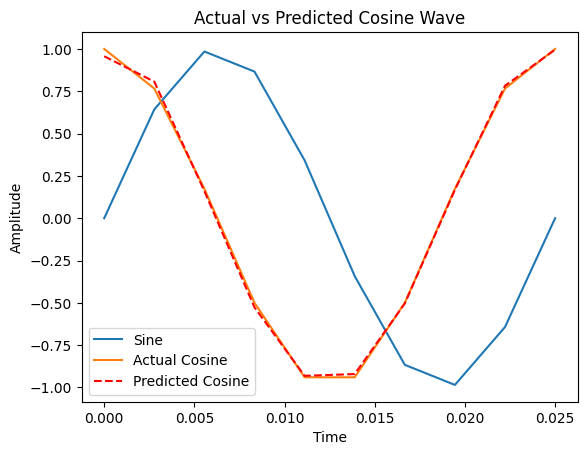

In [119]:
# Parameters
f = 40  # frequency in Hz
T = 1 / f  # period
sample_points = 10  # points per period
t = np.linspace(0, T, sample_points, endpoint=True)  # sampling times

# Generate sine and cosine sequences
sine_wave = np.sin(2 * np.pi * f * t)  # sine
cosine_wave = np.cos(2 * np.pi * f * t)  # cosine

# Convert to PyTorch tensors
sine_wave_tensor = torch.tensor(sine_wave, dtype=torch.float32).view(1, sample_points, 1)
cosine_wave_tensor = torch.tensor(cosine_wave, dtype=torch.float32).view(1, sample_points, 1)

# Define the GRU model to output the full sequence
class SineToCosineGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SineToCosineGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        gru_out, _ = self.gru(x)  # Get the GRU outputs for all time steps
        output = self.fc(gru_out)  # Pass through the fully connected layer for each time step
        return output

# Initialize model, loss, and optimizer
input_size = 1
hidden_size = 16
output_size = 1
model = SineToCosineGRU(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(sine_wave_tensor)  # Get predictions for all time steps
    loss = criterion(output, cosine_wave_tensor)  # Compare each predicted value with the actual cosine
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')

# Evaluation and visualization
model.eval()
predicted_cosine = model(sine_wave_tensor).detach().numpy().flatten()

# Plot the actual vs predicted cosine wave
plt.plot(t, sine_wave, label='Sine')
plt.plot(t, cosine_wave, label='Actual Cosine')
plt.plot(t, predicted_cosine, 'r--', label='Predicted Cosine')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Actual vs Predicted Cosine Wave')
plt.show()
